## Dataset

We are doing our analysis on [Spotify Multi-Genre Playlist Data](https://www.kaggle.com/siropo/spotify-multigenre-playlists-data).
This dataset is a collection of song features taken from Spotify and separated into six broad genres of music. 
Our analysis aims to answer to solve two problems:
1. How do you predict the genre of a song based on its features
2. What song features are more influential to a particular genre. 

It is not a random sampling of songs on Spotify: each song was on a playlist made by the person who collected the dataset. 
However, there is still a wide variety of genres it will work for purposes of our analysis. 
 
The dataset has the following 22 columns:

1. Artist Name
2. Song Name
3. Popularity: value from 1 to 100 that represents the song's popularity (magically determined by Spotify)
4. Genres: a detailed list of the genres for each artist
5. Playlist: the name of the playlist each song came from
6. Danceability
7. Energy
8. Key
9. Loudness
9. Mode
10. Speechiness
11. Acousticness
12. Instrumentalness
13. Liveness
14. Valence
15. Tempo
16. ID
17. URI
18. HRef
19. Analysis_url
19. Duration_Ms
20. Time-Signature

### Loading the dataset

The dataset is broken into 6 files, with each file containing the songs from a single genre of music. 
Here, we load the files into memory and combine them into one dataset. 
We also drop the playlist, ID, URI, HRef, and Analysis_url columns because they are not relevant for our analysis. 
Since we will be combining all of the songs into a single dataset, we also have to add another column containing the genre of each song. 

In [1]:
import pandas as pd

def load_dataset(music_genre):
    # First, we read the genre dataset into memory
    # Then we drop all of the columns we don't need
    # and finally we add the genre column and return it 
    return pd.read_csv(f'{music_genre}_music_data.csv').drop(columns=['Playlist', 'id', 'uri', 'track_href', 'analysis_url']).assign(genre=music_genre)

alternative = load_dataset('alternative')
blues = load_dataset('blues')
hiphop = load_dataset('hiphop')
indie_alt = load_dataset('indie_alt')
metal = load_dataset('metal')
pop = load_dataset('pop')
rock = load_dataset('rock')
    
dataset = pd.concat([alternative, blues, hiphop, indie_alt, metal, pop, rock])

### Dataset Meta Analysis

Before analysing our dataset, we want to figure out what we are working with regards to the number of songs in each genre and the missing values. 

In [2]:
def inspect_dataset_meta(music_genre):
    print('Genre:', music_genre)
    print('Number of songs:', len(dataset[dataset['genre'] == music_genre]))
    # thanks to Stack Overflow user piRSquared and their answer to this question:
    # https://stackoverflow.com/a/38733583
    print('Number of missing values:', (dataset[dataset['genre'] == music_genre].isna()).to_numpy().sum(), '\n')

genres = ['alternative', 'blues', 'hiphop', 'indie_alt', 'metal', 'pop', 'rock']

for genre in genres:
    inspect_dataset_meta(genre)
    
print('Number of songs in dataset:', len(dataset))

Genre: alternative
Number of songs: 2160
Number of missing values: 0 

Genre: blues
Number of songs: 2050
Number of missing values: 0 

Genre: hiphop
Number of songs: 2581
Number of missing values: 0 

Genre: indie_alt
Number of songs: 4338
Number of missing values: 0 

Genre: metal
Number of songs: 3045
Number of missing values: 0 

Genre: pop
Number of songs: 3831
Number of missing values: 0 

Genre: rock
Number of songs: 8747
Number of missing values: 0 

Number of songs in dataset: 26752


Fortunately, there are no missing values in this dataset, so we don't have to worry about that. 
There is a disproportionately large number of rock songs, so if we end up building a classifier, it may end up being biased towards rock (that may not be a bad thing, but what do I know? I'm also biased towards rock)

## Basic Data Exploration

In this section, we'll perform a few visualizations and calculate some statistics for our dataset.  

### Boxplots

We have created a box plot for each of the song features that we will be analyzing, and we have broken the plot of each feature into its respective genre. 
This will help us answer Question 2 (what features are most influential for a particular genre) we visually observe the mean and ranges that each genre has for each feature. 
If we find any medians and ranges for one genre that look particularly different than the other genres, we will know that it is a feature that we should investigate. 

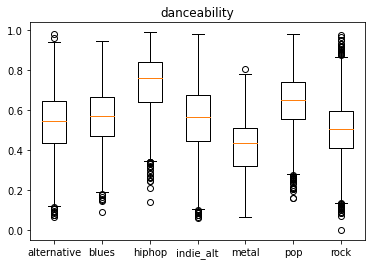

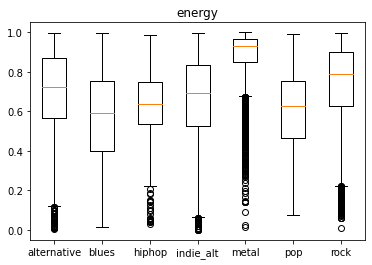

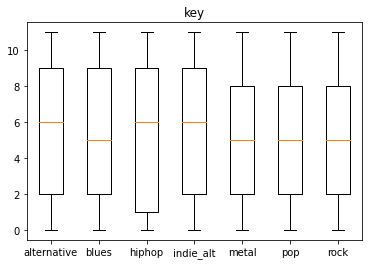

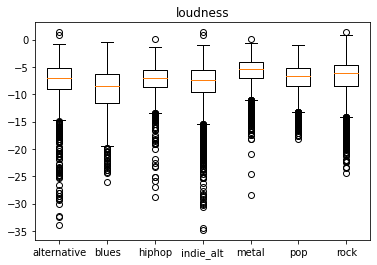

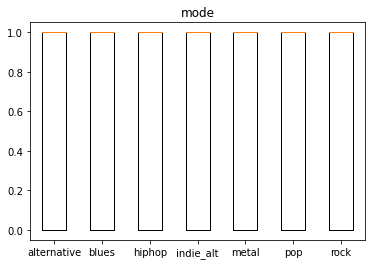

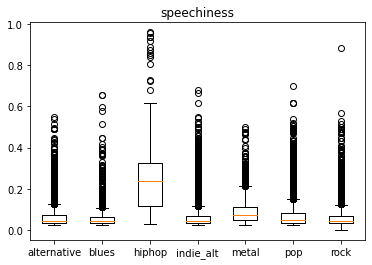

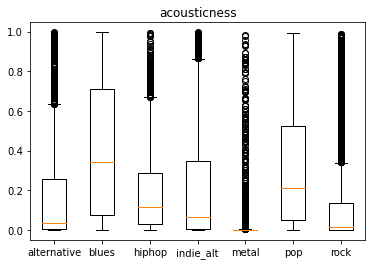

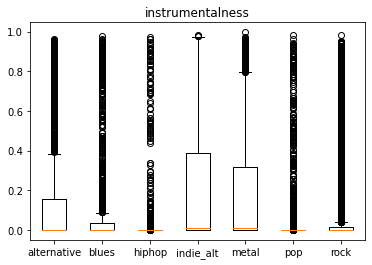

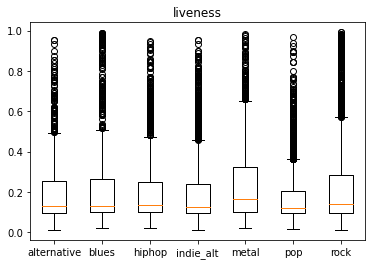

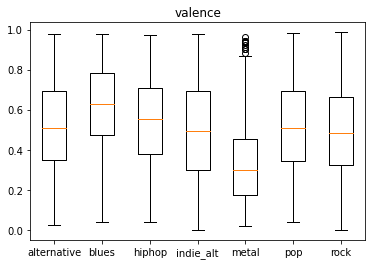

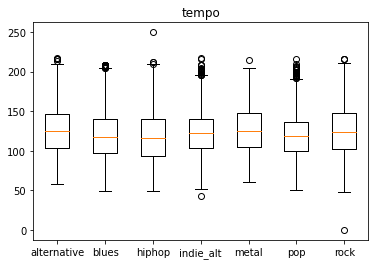

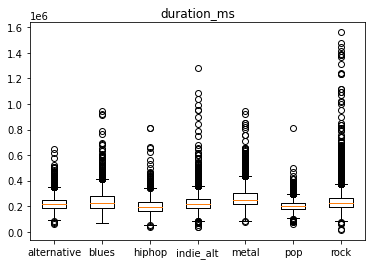

In [3]:
import matplotlib.pyplot as plt

def split_attribute_into_genres(att_name):
    return [alternative[att_name], 
            blues[att_name],
            hiphop[att_name],
            indie_alt[att_name],
            metal[att_name],
            pop[att_name],
            rock[att_name]]


for col in dataset.loc[:, 'danceability':'duration_ms']:
    fig, ax = plt.subplots()
    ax.boxplot(split_attribute_into_genres(col))
    ax.set_title(col)
    ax.set_xticklabels(genres)
    plt.show()
    

These box plots reveal some interesting patterns for certain songs. Here are our findings:

* The `energy` in metal songs is significantly higher than that for any other song.
This means that we should investigate using `energy` to differentiate metal songs from other songs.

* Likewise, the `valence` of metal songs is lower than the other genres, so we should investigate using valence to identify metal songs as well.

* Blues has a higher `acousticness` than any other genre

* Furthermore, the medians and ranges for `acousticness` seem to wildly vary from genre to genre, so we should investigate this property more

* The interquartile range of `instrumentalness` for hiphop and pop is too small to be seen on the plot, 
so we should investigate that property for identifying pop and hiphop songs. 

* `instrumentalness` in general appears to be an interesting property, with some genres having small ranges and others large ranges. 

* `Speechiness` is significantly higher in hiphop than it is in any other genre

* The tempo seems to be similar for each genre, so we probably shouldn't spend too much time exploring it


### Statistics

Now that we have created box plots for each song feature and identified some possible areas of interest, it is time to generate some statistics for those areas.

In [4]:
def generate_statistical_matrix(statistical_function):
    stat_dict = dict()
    for genre in genres:
        stat_dict[genre] = statistical_function(dataset[dataset['genre'] == genre].loc[:, 'danceability':'duration_ms'])
    
    return pd.DataFrame(stat_dict)

print('####################################')
print('Mean of Each Feature for Each Genre')   
print(generate_statistical_matrix(pd.DataFrame.mean))
print('####################################\n')
print('Standard Deviation of Each Feature for Each Genre')
print(generate_statistical_matrix(pd.DataFrame.std))
print('####################################')

####################################
Mean of Each Feature for Each Genre
                    alternative          blues         hiphop      indie_alt  \
danceability           0.536953       0.564278       0.733737       0.555842   
energy                 0.693046       0.572964       0.638692       0.661998   
key                    5.355556       5.432683       5.319256       5.383356   
loudness              -7.623776      -9.145411      -7.376902      -8.056145   
mode                   0.658796       0.667805       0.533514       0.656293   
speechiness            0.067556       0.062206       0.235685       0.066785   
acousticness           0.177995       0.399214       0.191144       0.217492   
instrumentalness       0.164318       0.086851       0.022999       0.218268   
liveness               0.188587       0.207691       0.197226       0.187769   
valence                0.513680       0.613717       0.538287       0.494158   
tempo                126.069160     121.604544 

It is harder to draw any good conclusions based solely off of the mean and standard deviation of each feature. 
These values do more to back up the patterns shown in the box plots, and to reveal some information that was obscured by the limitations of the box plots. 

* Possibly the best revelation is the connection between energy and metal. The average energy for metal songs over 1 standard deviation higher than the average energy for most other genres. 

* The mean instrumentalness of pop and hiphop are very similar, and they both have small standard deviations. 
This supports the hypothesis that instrumentalness would be a good candidate for identifying pop and hiphop songs.
However, their means are close to the means of other genres (especially ones with a higher standard deviation) so we will have to see how much it affects models in-pratice. 


## Analysis

### Logistic Regression

We will be using logistic regression to help answer the question: what song features are more influential to a particular genre? 
We'll accomplish this by creating a logistic model for each genre that determines whether a song is in that particular genre. 
We'll then analyze its coefficients to determine which ones are statistically significant. 
Since we are training each model in a '1 genre vs every other genre', the significant features are useful for identifying each specific genre. 

For example, the logistic regression for metal music will output either 1: a given song is metal, or 0: a given song is not metal. 
We expect that its energy coefficient will be statistically significant for the logistic regression due to the prior analysis that showed that metal songs typically have higher energy than non-metal songs. 

In [22]:
import statsmodels.api as sm

def build_regression(genre_name):
    # collect all of the songs that belong to the given genre (and ignore any columns that aren't song features)
    X_same_genre = dataset[dataset['genre'] == genre_name].loc[:, 'danceability':'duration_ms']
    # Collect the songs that don't belong to the given genre (collect only a random sample to ensure a balanced dataset)
    X_different_genre = dataset[dataset['genre'] != genre_name].loc[:,'danceability':'duration_ms'].sample(n=len(X_same_genre))
    
    X_train = pd.concat([X_same_genre, X_different_genre], ignore_index=True)
    
    # for the Y data, we just need to make a dataframe of all 1s or all 0s with the same length as the X data
    Y_same_genre = pd.DataFrame(index=range(len(X_same_genre)), columns=['genre']).assign(genre=1)
    Y_different_genre = pd.DataFrame(index=range(len(X_same_genre)), columns=['genre']).assign(genre=0)

    Y_train = pd.concat([Y_same_genre,Y_different_genre], ignore_index=True)

    return sm.Logit(Y_train, X_train).fit()
    
build_regression('metal').summary()
    
    

Optimization terminated successfully.
         Current function value: 0.424885
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  genre   No. Observations:                 6090
Model:                          Logit   Df Residuals:                     6078
Method:                           MLE   Df Model:                           11
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:                  0.3870
Time:                        16:22:26   Log-Likelihood:                -2587.6
converged:                       True   LL-Null:                       -4221.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
danceability        -4.6086      0.261    -17.636      0.000      -5.121      -4.096
energy               5.7027      0.245     23.272      0.000       5.222       6.183
key                 -0.0198      0.010     -2.021      0.043      -0.039      -0.001
loudness            -0.0621      0.015     -4.023      0.000      -0.092      -0.032
mode                -0.3581      0.071     -5.018      0.000      -0.498      -0.218
speechiness         -2.5663      0.594     -4.323      0.000      -3.730      -1.403
acousticness        -2.5991      0.281     -9.251      0.000      -3.150      -2.048
instrumentalness     0.4623      0.137      3.364      0.001       0.193       0.732
liveness            -0.4906      0.218     -2.255      0.024      -0.917      -0.064
valence             -3.5661      0.192    -18.604      0.000      -3.942      -3.190
tempo               -0.0079      0.001     -6.862      0.000      -0.010      -0.006
duration_ms       2.398e-06   4.48e-07      5.358      0.000    1.52e-06    3.28e-06
====================================================================================
"""